In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_svmlight_file
from scipy.optimize import fmin_l_bfgs_b
import torch
from opt_methods import compute_grad, gd, compute_grad_i, stoch_grad, adagrad, proximal_stochastic_grad, stochastic_BFGS
from problem import ClassPb

In [2]:
a_train, y = load_svmlight_file('data/mushrooms')
a_train, y = a_train.toarray(), y.astype(int)
a_val, y_val = load_svmlight_file('data/satimage.scale.val')
a_val, y_val = a_val.toarray(), y_val.astype(int)
y_train=y
y_train[y==2]=0

print(f"Length of training set: {len(a_train)}")
print(f"Length of validation set: {len(a_val)}")
print(f"Number of features: {a_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")


Length of training set: 8124
Length of validation set: 1331
Number of features: 112
Number of classes: 2


# Analysis of the data

In [3]:
a_train.shape

(8124, 112)

/Users/constouille/Documents/GitHub/L-BFGS/L-BFGS/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/constouille/Documents/GitHub/L-BFGS/L-BFGS/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


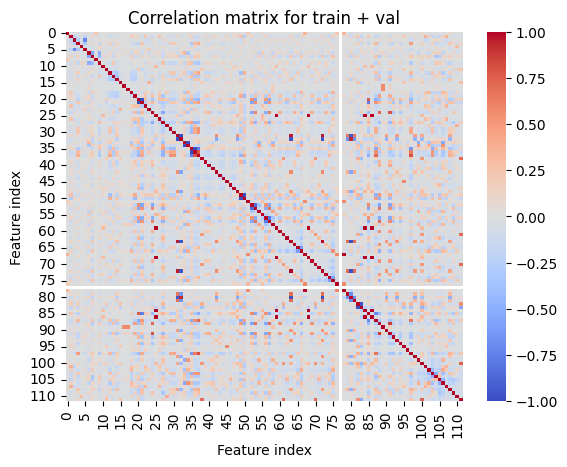

In [3]:
# Correlation matrix for train + val
# X = np.vstack([a_train, a_val])
# y = np.hstack([y_train, y_val])
X = a_train
y = y_train
corr_matrix = np.corrcoef(X.T)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation matrix for train + val")
plt.xlabel("Feature index")
plt.ylabel("Feature index")
plt.show()

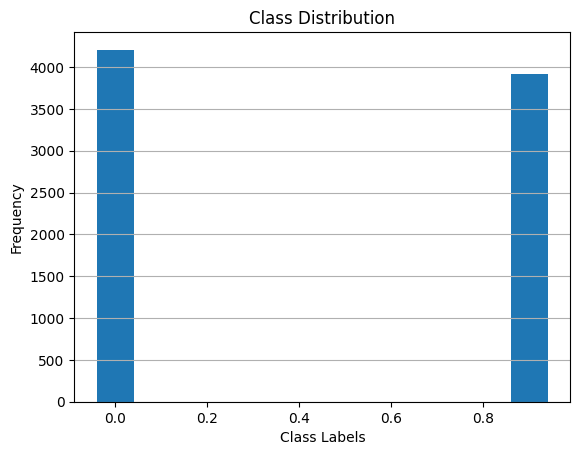

In [22]:
# Class distribution
plt.hist(y, align='left', rwidth=0.8)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.grid(axis='y')
plt.show()


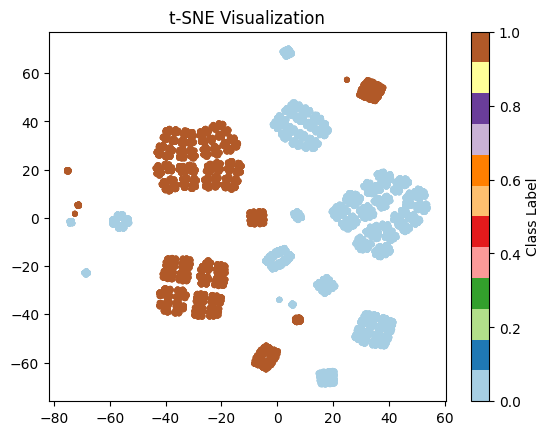

In [23]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='Paired', s=10)
plt.colorbar(label='Class Label')
plt.title('t-SNE Visualization')
plt.show()


# Autograd framework

In [3]:
problem = ClassPb(a_train, y_train)
problem.init_x()
problem.convert_to_torch()
grad = compute_grad_i(problem.obj_func_i, problem.x, 0)
grad

/Users/constouille/Documents/GitHub/L-BFGS/problem.py:58: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  z = self.A[i].T @ x


tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.2500, -0.0000, -0.2500,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.2500, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.2500, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.2500, -0.0000, -0.0000, -0.0000,
        -0.2500, -0.2500, -0.0000, -0.0000, -0.2500, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.2500, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.2500, -0.0000, -0.0000, -0.2500, -0.0000, -0.0000, -0.0000,
        -0.2500, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.2500, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.2500, -0.0000, -0.2500, -0.0000, -0.0000,
        -0.2500, -0.0000, -0.0000, -0.2500, -0.0000, -0.2500, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.2500, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.00

In [4]:
# Sanity check with explicit formula
problem.init_x()
grad_e  = problem.grad_explicit(problem.x, 0)
grad = compute_grad_i(problem.obj_func_i, problem.x, 0)
assert torch.allclose(grad_e, grad, atol=1e-6), "Gradients do not match at index level!"
print("Gradients match at index level!")
grad_e = 0
grad_autograd = 0
for i in range(problem.A.shape[0]):
    grad_e += problem.grad_explicit(problem.x, i).detach()
    grad_autograd += compute_grad_i(problem.obj_func_i, problem.x, i)
    #assert torch.allclose(grad_e, grad, atol=1e-6), f"Mismatch at index {i}!"
    #print(f"Index {i}: Explicit Grad = {grad_e}, Autograd Grad = {grad}")

grad_e = grad_e / problem.A.shape[0]
grad_autograd = grad_autograd / problem.A.shape[0]
grad = compute_grad(problem.obj_func, problem.x)

assert torch.allclose(grad, grad_autograd, atol=1e-6), "Gradients do not match at vector level!"
assert torch.allclose(grad, grad_e, atol=1e-6), "Gradients do not match at vector level!"
print("Gradients match at vector level!")

Gradients match at index level!
Gradients match at vector level!


In [4]:
x0=np.zeros(problem.d)
x_min, f_min, _ = fmin_l_bfgs_b(problem.obj_func, x0, grad, args=(), pgtol=1e-30, factr =1e-30)

# First order algorithms

In [6]:
# Gradient descent
problem.init_x()
opt_stepsize = 2/problem.lipgrad()
obj_list = gd(problem, opt_stepsize, n_iter=100, verbose=True)

Gradient Descent:
  iter   |   fval  
       0 | 2.50e-01
       1 | 2.35e-01
       2 | 2.22e-01
       3 | 2.09e-01
       4 | 1.98e-01
       5 | 1.88e-01
       6 | 1.79e-01
       7 | 1.71e-01
       8 | 1.63e-01
       9 | 1.57e-01
      10 | 1.51e-01
      11 | 1.45e-01
      12 | 1.40e-01
      13 | 1.35e-01
      14 | 1.31e-01
      15 | 1.27e-01
      16 | 1.23e-01
      17 | 1.20e-01
      18 | 1.17e-01
      19 | 1.14e-01
      20 | 1.11e-01
      21 | 1.09e-01
      22 | 1.06e-01
      23 | 1.04e-01
      24 | 1.02e-01
      25 | 1.00e-01
      26 | 9.84e-02
      27 | 9.67e-02
      28 | 9.51e-02
      29 | 9.35e-02
      30 | 9.20e-02
      31 | 9.06e-02
      32 | 8.93e-02
      33 | 8.80e-02
      34 | 8.68e-02
      35 | 8.56e-02
      36 | 8.45e-02
      37 | 8.34e-02
      38 | 8.24e-02
      39 | 8.14e-02
      40 | 8.04e-02
      41 | 7.95e-02
      42 | 7.86e-02
      43 | 7.77e-02
      44 | 7.69e-02
      45 | 7.61e-02
      46 | 7.53e-02
      47 | 7.46e-02
  

In [28]:
[10/L, 2/L, 1/L, 0.05]

[tensor(0.9524, dtype=torch.float64),
 tensor(0.1905, dtype=torch.float64),
 tensor(0.0952, dtype=torch.float64),
 0.05]

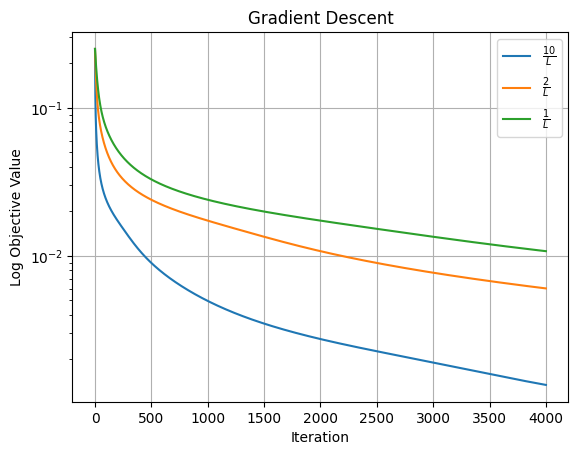

In [13]:
L = problem.lipgrad()
stepsizes = [10/L, 2/L, 1/L]
labels = [r"$\frac{10}{L}$", r"$\frac{2}{L}$", r"$\frac{1}{L}$"]
for i, stepsize in enumerate(stepsizes):
    problem.init_x()
    obj_vals = gd(problem, stepsize=stepsize, n_iter=4000, verbose=False)
    plt.semilogy(obj_vals - f_min, label = labels[i])
plt.xlabel("Iteration")
plt.ylabel("Log Objective Value")
plt.title("Gradient Descent")
plt.legend()
plt.grid(True)

# SGD

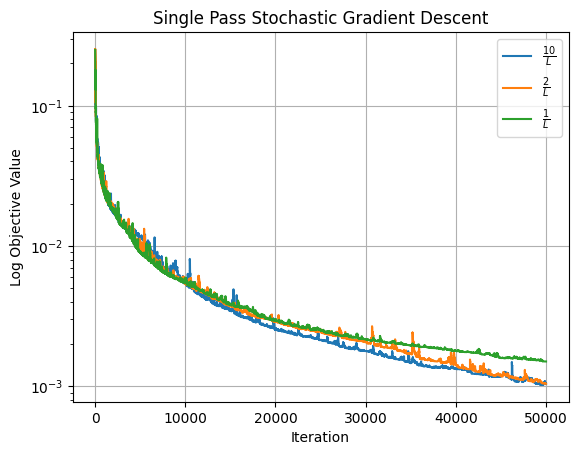

In [14]:
L = problem.lipgrad()
stepsizes = [10/L, 2/L, 1/L]
labels = [r"$\frac{10}{L}$", r"$\frac{2}{L}$", r"$\frac{1}{L}$"]
for i, stepsize in enumerate(stepsizes):
    problem.init_x()
    x, obj_vals, normits = stoch_grad(problem, stepchoice=0, n_iter=50000, verbose=False)
    plt.semilogy(obj_vals - f_min, label = labels[i])
plt.xlabel("Iteration")
plt.ylabel("Log Objective Value")
plt.title("Single Pass Stochastic Gradient Descent")
plt.legend()
plt.grid(True)

7590
7590
7590
7590
7590


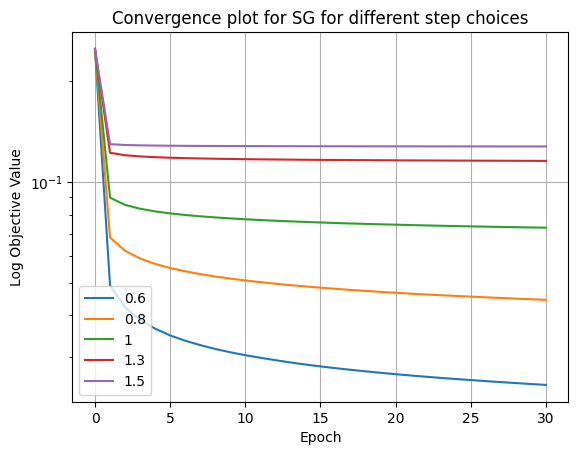

In [18]:
L = problem.lipgrad()
stepchoices = [0.6,0.8,1,1.3,1.5]
batch_step = problem.A.shape[0] // 32
for i, stepchoice in enumerate(stepchoices):
    problem.init_x()
    x, obj_vals, normits = stoch_grad(problem, stepchoice= stepchoice, n_epoch = 30, verbose=False, nb = 32)
    epoch_obj_vals = np.array([obj_vals[i] for i in range(0, len(obj_vals), batch_step)])
    plt.semilogy(epoch_obj_vals - f_min, label = stepchoice)
plt.xlabel("Epoch")
plt.ylabel("Log Objective Value")
plt.title("Convergence plot for SG for different step choices")
plt.legend()
plt.grid(True)

243720
1 8124.0
15210
16 507.75
7590
32 253.875
3780
64 126.9375
1890
128 63.46875
930
256 31.734375
450
512 15.8671875


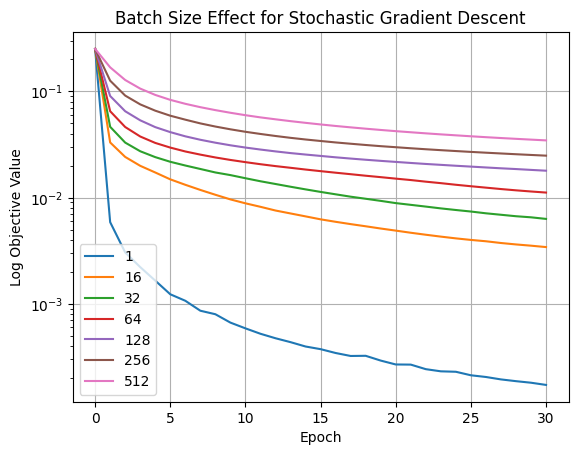

In [17]:
batch_sizes = [1, 16, 32, 64, 128, 256, 512]
for i, batch_size in enumerate(batch_sizes):
    problem.init_x()
    x, obj_vals, normits = stoch_grad(problem, stepchoice=0, n_epoch=30, verbose=False, nb=batch_size)
    batch_step = problem.A.shape[0] * 1 / batch_size
    print(batch_size, batch_step)
    epoch_obj_vals = np.array([obj_vals[i] for i in range(0, len(obj_vals), int(batch_step))])
    plt.semilogy(epoch_obj_vals - f_min, label = batch_size)
plt.xlabel("Epoch")
plt.ylabel("Log Objective Value")
plt.title("Batch Size Effect for Stochastic Gradient Descent")
plt.legend()
plt.grid(True)

# Adagrad

In [7]:
problem.init_x()
batch_size = 1
x, obj_vals, normits = adagrad(problem, x_min, stepchoice=0, n_epoch=30, verbose=False, nb=batch_size, scaling=1)
problem.init_x()
x_stoch, obj_vals_stoch, normits_stoch = stoch_grad(problem, stepchoice=0, n_epoch=30, verbose=False, nb=batch_size)


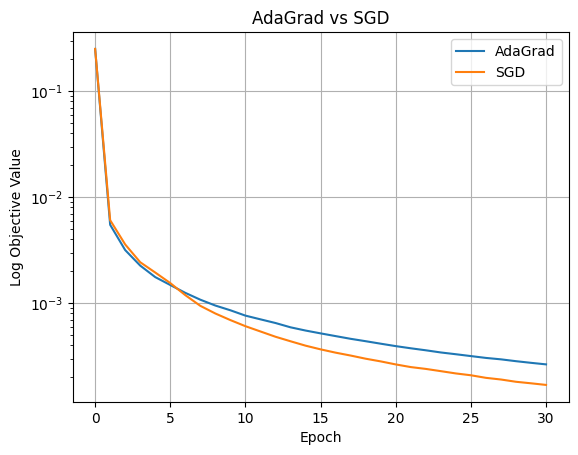

In [13]:
batch_step = problem.A.shape[0]  // batch_size
epoch_obj_vals_stoch = np.array([obj_vals_stoch[i] for i in range(0, len(obj_vals_stoch), batch_step)])
plt.semilogy(obj_vals - f_min, label = "AdaGrad")
plt.semilogy(epoch_obj_vals_stoch - f_min, label = "SGD")
plt.xlabel("Epoch")
plt.ylabel("Log Objective Value")
plt.title("AdaGrad vs SGD")
plt.legend()
plt.grid(True)

# Proximal version for the regularized problem

0.01
0.05
0.1
1


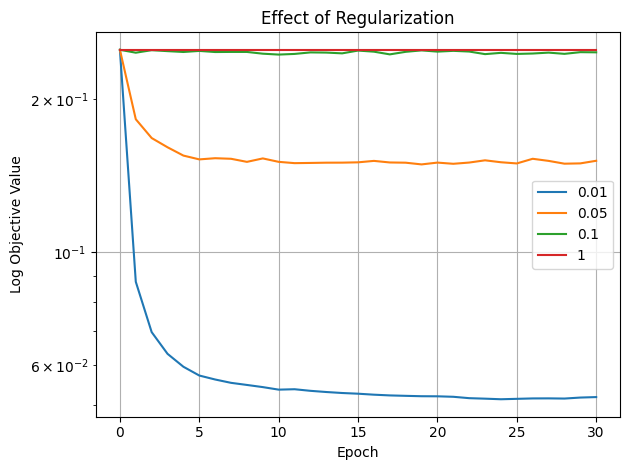

In [11]:
lambdas = [0.01, 0.05, 0.1, 1]
batch_step = problem.A.shape[0] // 64
list_x = []
for i, lambd in enumerate(lambdas):
    print(lambd)
    problem.init_x()
    x, obj_vals, normits = proximal_stochastic_grad(problem, lambd, stepchoice=0, n_epoch=30, verbose=False, nb=64)
    list_x.append(x)
    epoch_obj_vals = np.array([obj_vals[i] for i in range(0, len(obj_vals), batch_step)])
    plt.semilogy(epoch_obj_vals - f_min, label = lambd)
plt.xlabel("Epoch")
plt.ylabel("Log Objective Value")
plt.legend()
plt.title("Effect of Regularization")
plt.grid(True)
plt.tight_layout()

Number of 0 in x for lambda = 0.01: 90
Number of 0 in x for lambda = 0.05: 104
Number of 0 in x for lambda = 0.1: 111
Number of 0 in x for lambda = 1: 112


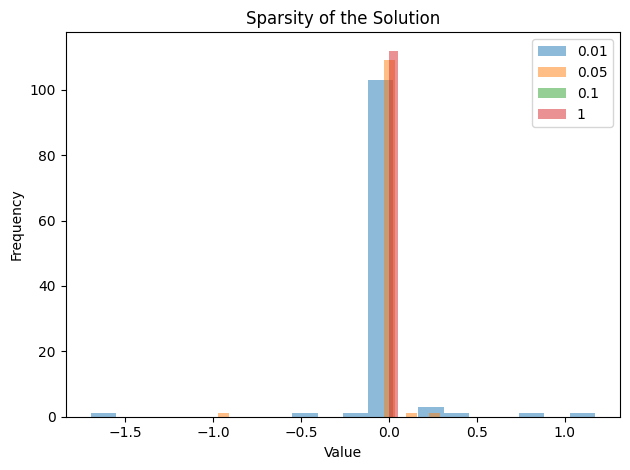

In [19]:
# Sparisty of the solution
for i, x in enumerate(list_x):
    plt.hist(x, bins=20, alpha=0.5, label=lambdas[i])
    print(f"Number of 0 in x for lambda = {lambdas[i]}: {np.sum(x.numpy() == 0)}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Sparsity of the Solution")
plt.legend()
plt.tight_layout()


# Quasi Newton Techniques

In [5]:
problem.init_x()
x, obj_vals = stochastic_BFGS(problem, n_epoch=30, verbose=False, nb=32, step0 = 1, stepchoice= 1)

/Users/constouille/Documents/GitHub/L-BFGS/opt_methods.py:426: UserWarning: Tensor.T is deprecated on 0-D tensors. This function is the identity in these cases. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3691.)
  H = (torch.eye(problem.d) - term1) @ H @ (torch.eye(problem.d) - term1.T) + (s @ s.T) / s_T_v


In [6]:
obj_vals

tensor([51.5827, 51.5533, 51.6268, 51.5860, 51.5827, 51.5710, 51.5943, 51.5924,
        51.5827, 51.5677, 51.5827, 51.5906, 51.5971, 51.5677, 51.5786, 51.5840,
        51.5827, 51.5827, 51.5795, 51.5881, 51.5146, 51.6570, 51.5690, 51.5949,
        51.6781, 51.5827, 51.5640, 51.4403, 51.6182, 51.6130, 51.5906, 51.5671,
        51.6046, 51.6156, 51.5561, 51.4909, 51.6808, 51.6362, 51.5796, 51.5861,
        51.6108, 51.5719, 51.5671, 51.5353, 51.5995, 51.5827, 51.5671, 51.5799,
        51.5827, 51.6379, 51.5337, 51.5827, 51.4870, 51.6837, 51.5837, 51.5827,
        51.5196, 51.6646, 51.5702, 51.5827, 51.6128, 51.5796, 51.5547, 51.5671,
        51.6051, 51.5945, 51.5716, 51.5827, 51.5827, 51.5938, 51.5827, 51.5388,
        51.5671, 51.6128, 51.6054, 51.5847, 51.5827, 51.5889, 51.5827, 51.5749,
        51.6046, 51.5749, 51.5796, 51.5920, 51.5827, 51.5143, 51.5827, 51.6017,
        51.6384, 51.5827, 51.5671, 51.6627, 51.5470, 51.5827, 51.5131, 51.5827,
        51.5797, 51.6331, 51.5827, 51.56

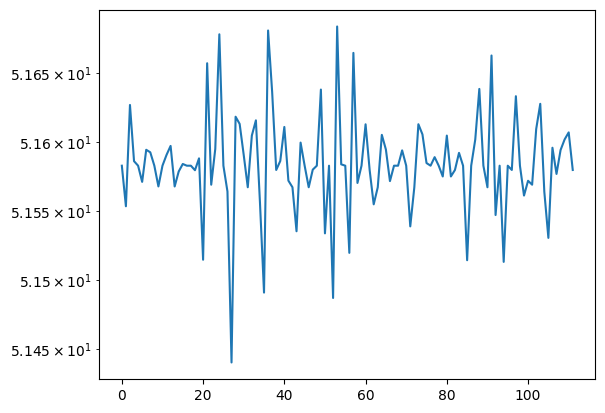

In [8]:
plt.semilogy(obj_vals - f_min)